#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
!pip install lightgbm -q

In [2]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
import warnings
warnings.filterwarnings('ignore')

## Подготовка

In [3]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)

# Ресемплирование по одному часу так как  взадании проноз на час
data = data.resample('1H').sum()
# Инфо
print(data.head(10))
print(data.info())

                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43
2018-03-01 05:00:00           6
2018-03-01 06:00:00          12
2018-03-01 07:00:00          15
2018-03-01 08:00:00          34
2018-03-01 09:00:00          69
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB
None


Вывод: В датасете имеются данные по количеству заказов такси с первого марта по 31 августа за 2018 год в размере 4416 значений. Так как в задании говорится о предсказании на час врепед то просумируем данные за час. 

## Анализ

In [4]:
# Проверка на дубликаты
duplicate_index = data.index.duplicated()
print(f"Дубликаты в индексе: {duplicate_index.sum()}")


Дубликаты в индексе: 0


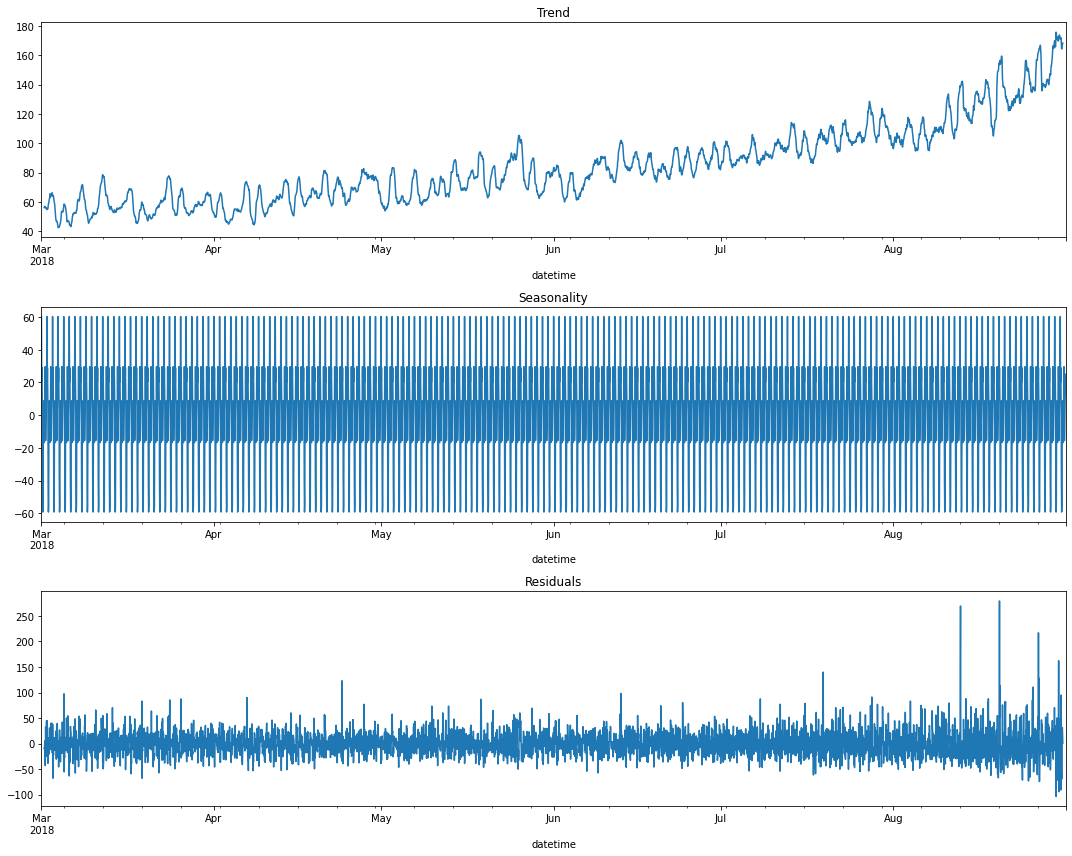

In [5]:
# Проведем сезонную декомпозицию (аддитивная модель)
decomposed = seasonal_decompose(data)
# Построим графики декомпозиции
plt.figure(figsize=(15, 12))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

<AxesSubplot:xlabel='datetime'>

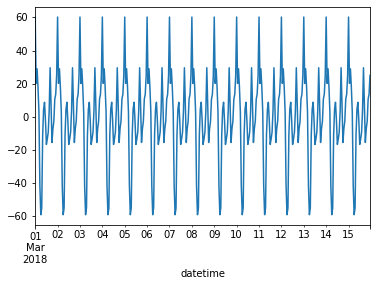

In [6]:
decomposed.seasonal['2018-03-01':'2018-03-15'].plot()

In [7]:
data['hour'] = data.index.hour
data['dayofweek'] = data.index.dayofweek
data['month'] = data.index.month

В данных нет дубликатов. По часам заказы распределны неравномерно со средним 60-80 заков и с просадкой в райне 5-7 часов до 20-40  и резким пиком в 0 часов до 140 и в 2

## Создание признака и разделение данных на тренировочную и тестовую

In [8]:
## Создание признака
def make_features(data, max_lag, rolling_mean_size):
    data = data.copy()
    
    # Лаговые признаки (значения в предыдущие часы)
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)
    
    # Скользящее среднее (для выявления тренда)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data

# Создаем признаки
data = make_features(data, max_lag=10, rolling_mean_size=10)

# Удаляем строки с NaN
data = data.dropna()

# Разделяем на признаки и целевую переменную
X = data.drop('num_orders', axis=1)
y = data['num_orders']
print(X.shape)
print(y.shape)

(4406, 14)
(4406,)


In [9]:
#Разбивка данных на тестовую и  тренировочную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)
                
# Проверяем даты разделения
print(f"Дата начала train: {y_train.index[0]}")
print(f"Дата окончания train: {y_train.index[-1]}")
print(f"Дата начала test: {y_test.index[0]}")
print(f"Дата окончания test: {y_test.index[-1]}")
print(f"Длина test выборки: {len(y_test)} часов ({len(y_test)/24:.1f} дней)")

Дата начала train: 2018-03-01 10:00:00
Дата окончания train: 2018-08-13 14:00:00
Дата начала test: 2018-08-13 15:00:00
Дата окончания test: 2018-08-31 23:00:00
Длина test выборки: 441 часов (18.4 дней)


## Обучение

In [10]:
#1.RandomForest
# Настройка гиперпараметров 
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

# Параметры для перебора
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_leaf': [5, 10]
}

# Используем TimeSeriesSplit для кросс-валидации
tscv = TimeSeriesSplit(n_splits=3)

# Поиск по сетке
rf_grid = GridSearchCV(rf_model, rf_params, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid.fit(X_train, y_train)

# Лучшая модель
best_rf = rf_grid.best_estimator_

# Предсказание на тренировочной выборке для лучшей модели
rf_train_predictions = best_rf.predict(X_train)

# Оценка качества на тренировочной выборке
rf_train_rmse = np.sqrt(mean_squared_error(y_train, rf_train_predictions))
print(f'RandomForest Train RMSE: {rf_train_rmse}')
print(f'Best params: {rf_grid.best_params_}')

RandomForest Train RMSE: 14.844773289404026
Best params: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 50}


In [11]:
# 2. LGBM
# подбор  гиперпараметров
lgbm_params = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0]
}

lgbm_model = LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1)

lgbm_grid = GridSearchCV(
    lgbm_model, 
    lgbm_params, 
    cv=tscv,  
    scoring='neg_mean_squared_error', 
    n_jobs=-1,
    verbose=1
)

lgbm_grid.fit(X_train, y_train)

best_lgbm = lgbm_grid.best_estimator_
lgbm_predictions = best_lgbm.predict(X_train)
lgbm_rmse = np.sqrt(mean_squared_error(y_train, lgbm_predictions))

print(f'LGBM RMSE: {lgbm_rmse:.2f}')
print(f'Best params: {lgbm_grid.best_params_}')

Fitting 3 folds for each of 36 candidates, totalling 108 fits
LGBM RMSE: 15.18
Best params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


In [12]:
#3 Линейная регрессия
scaler = StandardScaler()

# Модель с регуляризацией
ridge_model = make_pipeline(scaler, Ridge(random_state=42))

ridge_params = {
    'ridge__alpha': [0.1, 1.0, 10.0]
}

ridge_grid = GridSearchCV(ridge_model, ridge_params, cv=tscv, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train, y_train)

best_ridge = ridge_grid.best_estimator_
ridge_predictions = best_ridge.predict(X_train)


ridge_rmse = np.sqrt(mean_squared_error(y_train, ridge_predictions))
print(f'Ridge Regression RMSE: {ridge_rmse:.2f}')

Ridge Regression RMSE: 30.38


Все ошибки RMSE для трех модлей (Случайный лес, LGBM , линейная регрессия с нормализацией) на тренировочных данных получились меньше 48. Наименьшим обладает Случайный лес, чуть больше LGMB (Хотя если проверить на тестовых данных то лучшей метрикой будет обладать LGBM) поэтому для прогноза выберем модель Случайного леса. 

Вопрос по логике: На первом этапе все понятно мы кросвалидацией подбираем гиперпараметры для увеличения метрики и по тренировочным даннм выбираем модель потом ее тестируем на тестовых данных. Если модель переобучилась и показывает ухудшение метрики то что делают инженеры тестят вторую модель? переобучают заново но с меньшими геперпараметрами? или вообще базовую?

## Тестирование

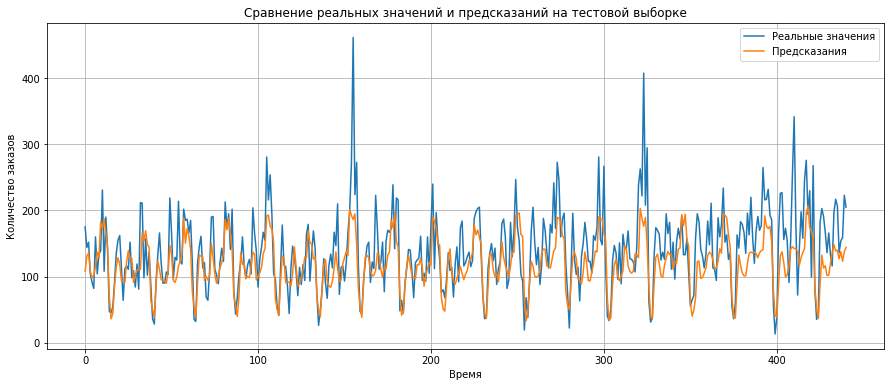

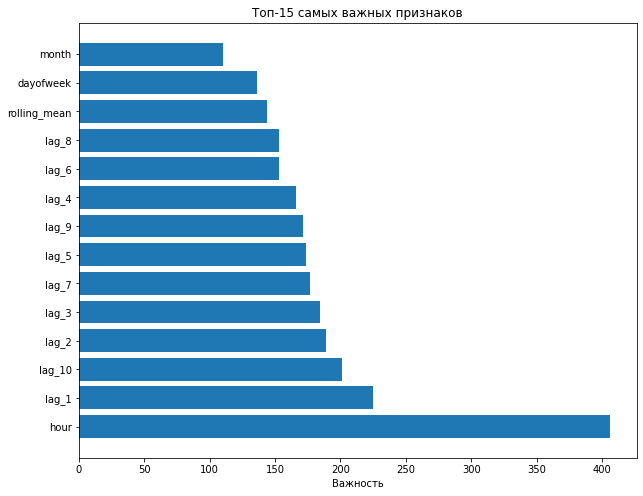

RMSE на тестовой выборке: 45.4948850479117


In [13]:
# Визуализация предсказаний лучшей модели
predictions =best_rf.predict(X_test)


plt.figure(figsize=(15, 6))
plt.plot(y_test.values, label='Реальные значения')
plt.plot(predictions, label='Предсказания')
plt.title('Сравнение реальных значений и предсказаний на тестовой выборке')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.legend()
plt.grid(True)
plt.show()

# Важность признаков
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_lgbm.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'][:15], feature_importance['importance'][:15])
plt.title('Топ-15 самых важных признаков')
plt.xlabel('Важность')
plt.show()

# Расчет RMSE на тестовой выборке

lgbm_rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'RMSE на тестовой выборке: {lgbm_rmse}')

Модуль случайного леса предсказывает на тестовых данных с RMSE 45.5 что удовлетворяет условию. Такое расхождение обьясняется резким ростом в 160 и 330 днем, что сильно влияет на метрику.  Самым важным признаком влиящим на количтсво заказов это час

Итоговый вывод:
1)В датасете имеются данные по количеству заказов такси с первого марта по 31 августа за 2018 год в размере 4416 значений. Так как в задании говорится о предсказании на час врепед то просумируем данные за час. 
2)Имеется общий тренд на увеличение количества поездок ото марта к августу (конечно было бы интерсно иметь данные за год, будет ли затухание после отпусков). Высокая сезонность, с помощью графиика недельного интервала видно что1  день. Остатки в августе сильно скочат, что может повлиять на модель. Добавим вспомогательные признаки час, день недели, месяц для повышения качества модели
3)Все ошибки RMSE для трех модлей (Случайный лес, LGBM , линейная регрессия с нормализацией) на тренировочных данных получились меньше 48. Наименьшим обладает Случайный лес, чуть больше LGMB (Хотя если проверить на тестовых данных то лучшей метрикой будет обладать LGBM) поэтому для прогноза выберем модель Случайного леса. 
4)Модуль случайного леса предсказывает на тестовых данных с RMSE 45.5 что удовлетворяет условию. Такое расхождение обьясняется резким ростом в 160 и 330 днем, что сильно влияет на метрику.  Самым важным признаком влиящим на количтсво заказов это час